In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
import seaborn as sns
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/real_estate2.xlsx")

In [5]:
df.head()

,id,station,distance,space,room,year,type,value
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190


数値化１：築年数に（2018年ベース）

In [6]:
df["elapsed"] = 2018 - df["year"]

数値化２：距離の数値化

In [7]:
df["distance"].unique()

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [8]:
dis_arr = df["distance"].unique()

In [9]:
dis_arr

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [10]:
dis_dict = {dis_arr[0]:10, dis_arr[1]:15, dis_arr[2]:5, dis_arr[3]:20, dis_arr[4]:30, dis_arr[5]:np.nan}

In [11]:
dis_dict

{'徒歩10分以内': 10, '徒歩15分以内': 15, '徒歩5分以内': 5, '徒歩15分超': 20, 'バス': 30, '-': nan}

In [12]:
df["distance2"] = df["distance"].apply(lambda x:dis_dict[x])  # dictで変換

数値化（前処理）の確認として、、、

In [13]:
df.head()

,id,station,distance,space,room,year,type,value,elapsed,distance2
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910,35,10.0
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120,35,10.0
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190,35,10.0
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190,35,10.0
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190,35,10.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         200 non-null    int64  
 1   station    200 non-null    object 
 2   distance   200 non-null    object 
 3   space      200 non-null    int64  
 4   room       200 non-null    object 
 5   year       200 non-null    int64  
 6   type       200 non-null    object 
 7   value      200 non-null    int64  
 8   elapsed    200 non-null    int64  
 9   distance2  197 non-null    float64
dtypes: float64(1), int64(5), object(4)
memory usage: 15.8+ KB


In [15]:
df = df.dropna()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 0 to 199
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         197 non-null    int64  
 1   station    197 non-null    object 
 2   distance   197 non-null    object 
 3   space      197 non-null    int64  
 4   room       197 non-null    object 
 5   year       197 non-null    int64  
 6   type       197 non-null    object 
 7   value      197 non-null    int64  
 8   elapsed    197 non-null    int64  
 9   distance2  197 non-null    float64
dtypes: float64(1), int64(5), object(4)
memory usage: 16.9+ KB


In [17]:
df2 = df[["space","elapsed","distance2","value"]]

In [18]:
df2.head()

,space,elapsed,distance2,value
0,70,35,10.0,910
1,70,35,10.0,1120
2,70,35,10.0,1190
3,70,35,10.0,1190
4,70,35,10.0,1190


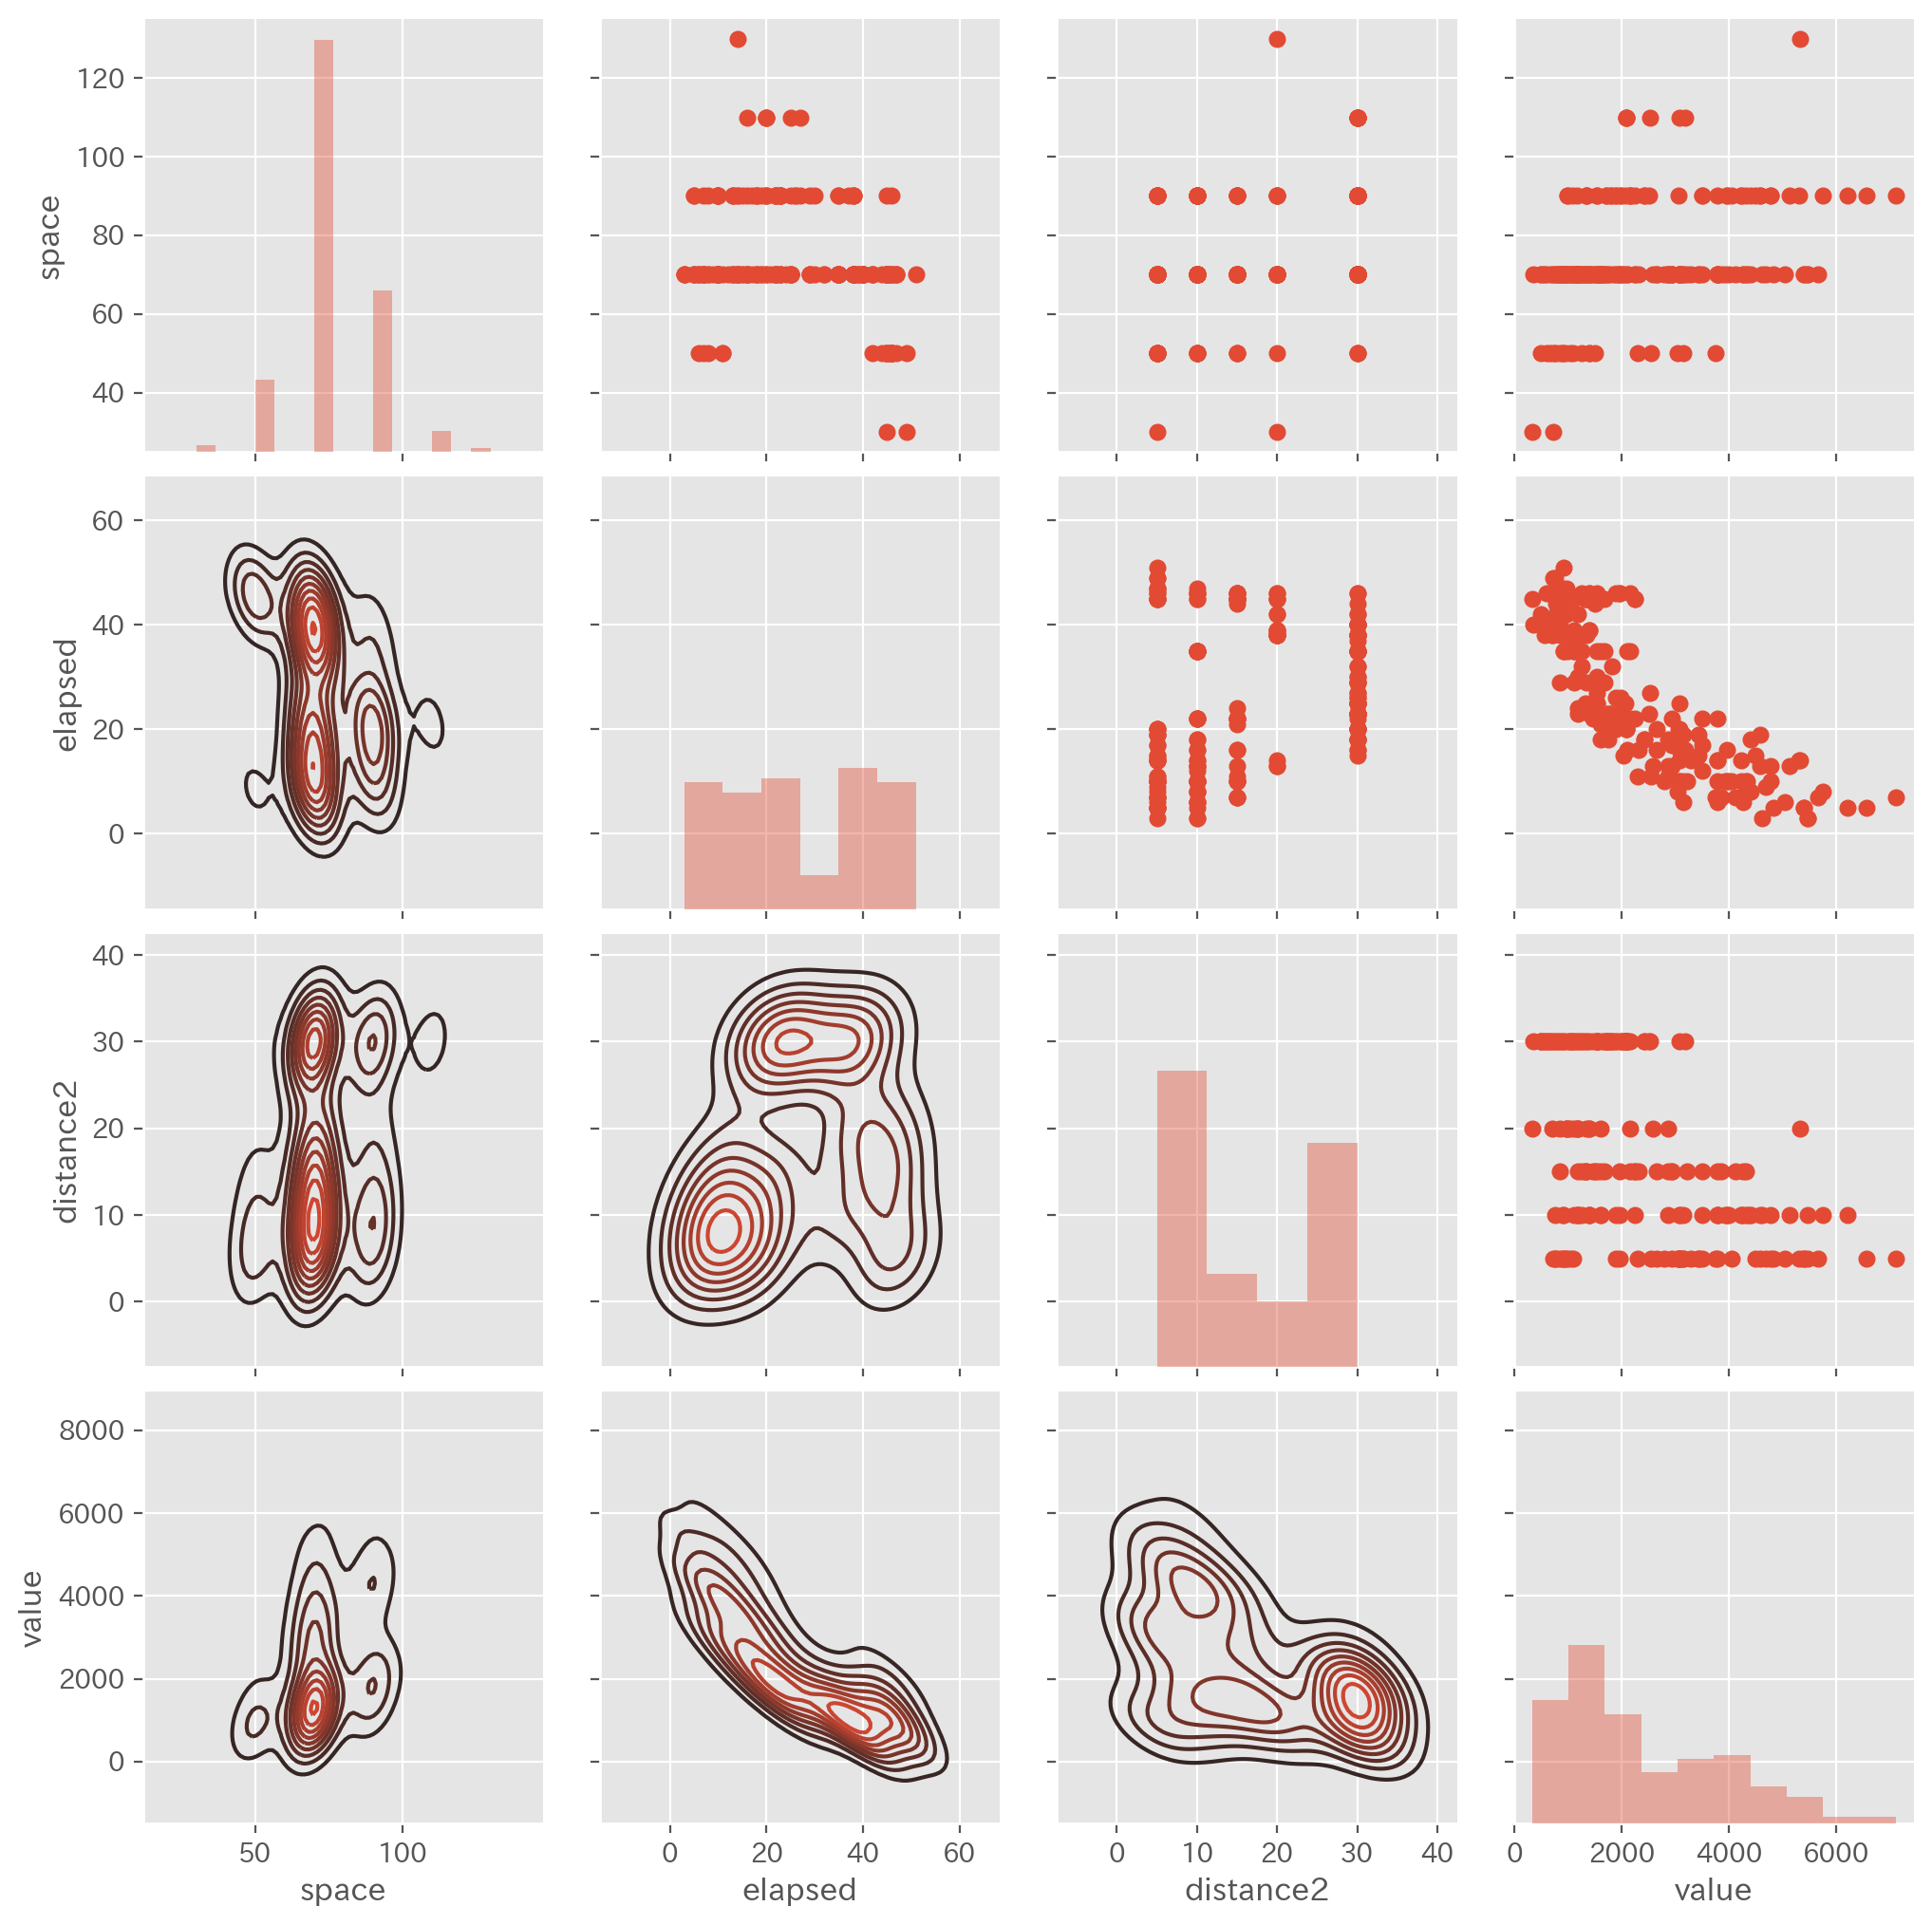

In [19]:
g = sns.PairGrid(df2)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.distplot, kde=False)  # 対角成分（diag） kde=False -> histになる
g = g.map_upper(plt.scatter)

In [20]:
stan_model = """
data {
  int N;
  real elapsed[N];
  real dis[N];
  real space[N];
  real Y[N];
}

parameters {
  real d;
  real s;
  real e;
  real b;
  real<lower=0> sigma;
}

model {
  real mu;
  for (n in 1:N){
    mu = e * elapsed[n] + d * dis[n] + s * space[n] + b;
    Y[n] ~ normal(mu, sigma);
  }
}

"""

In [21]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aaf2e8dabdfaaa9b3e5a603a25c838cc NOW.


In [22]:
stan_data = {"N":df.shape[0],"elapsed":df["elapsed"],"dis":df["distance2"], "space":df["space"], "Y":df["value"]}

In [23]:
fit = sm.sampling(data = stan_data, iter=2000, warmup=500, chains=4, seed=123)

In [24]:
fit

Inference for Stan model: anon_model_aaf2e8dabdfaaa9b3e5a603a25c838cc.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d     -57.59    0.09   5.19 -67.97 -61.13 -57.54 -54.17 -47.36   3589    1.0
s      24.48    0.08    3.6  17.33  22.11  24.46  26.95   31.3   2210    1.0
e     -67.73    0.07   3.75 -74.93 -70.27 -67.78  -65.2 -60.25   3054    1.0
b     3311.0     6.4 298.53 2743.8 3106.9 3306.9 3508.2 3907.6   2178    1.0
sigma 636.81     0.5   33.3 575.37 613.78 635.34 657.63 705.78   4367    1.0
lp__   -1363    0.03   1.63  -1367  -1364  -1363  -1362  -1361   2303    1.0

Samples were drawn using NUTS at Tue May  5 11:59:22 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

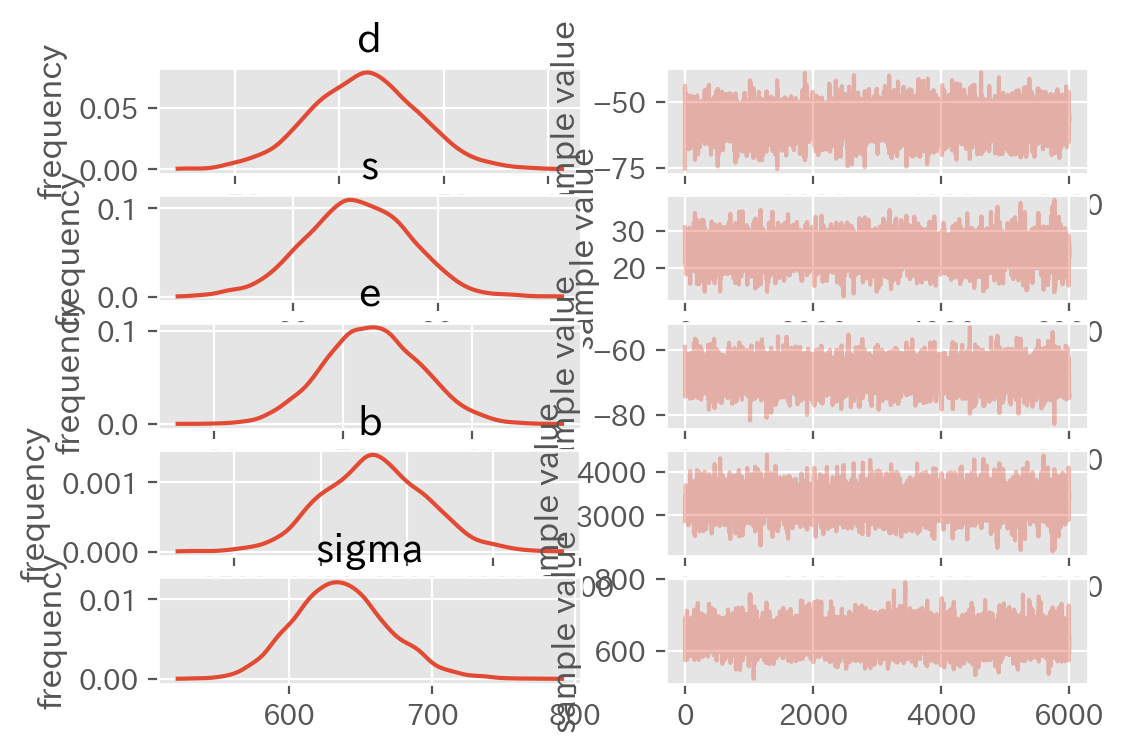

In [25]:
fig = fit.plot()

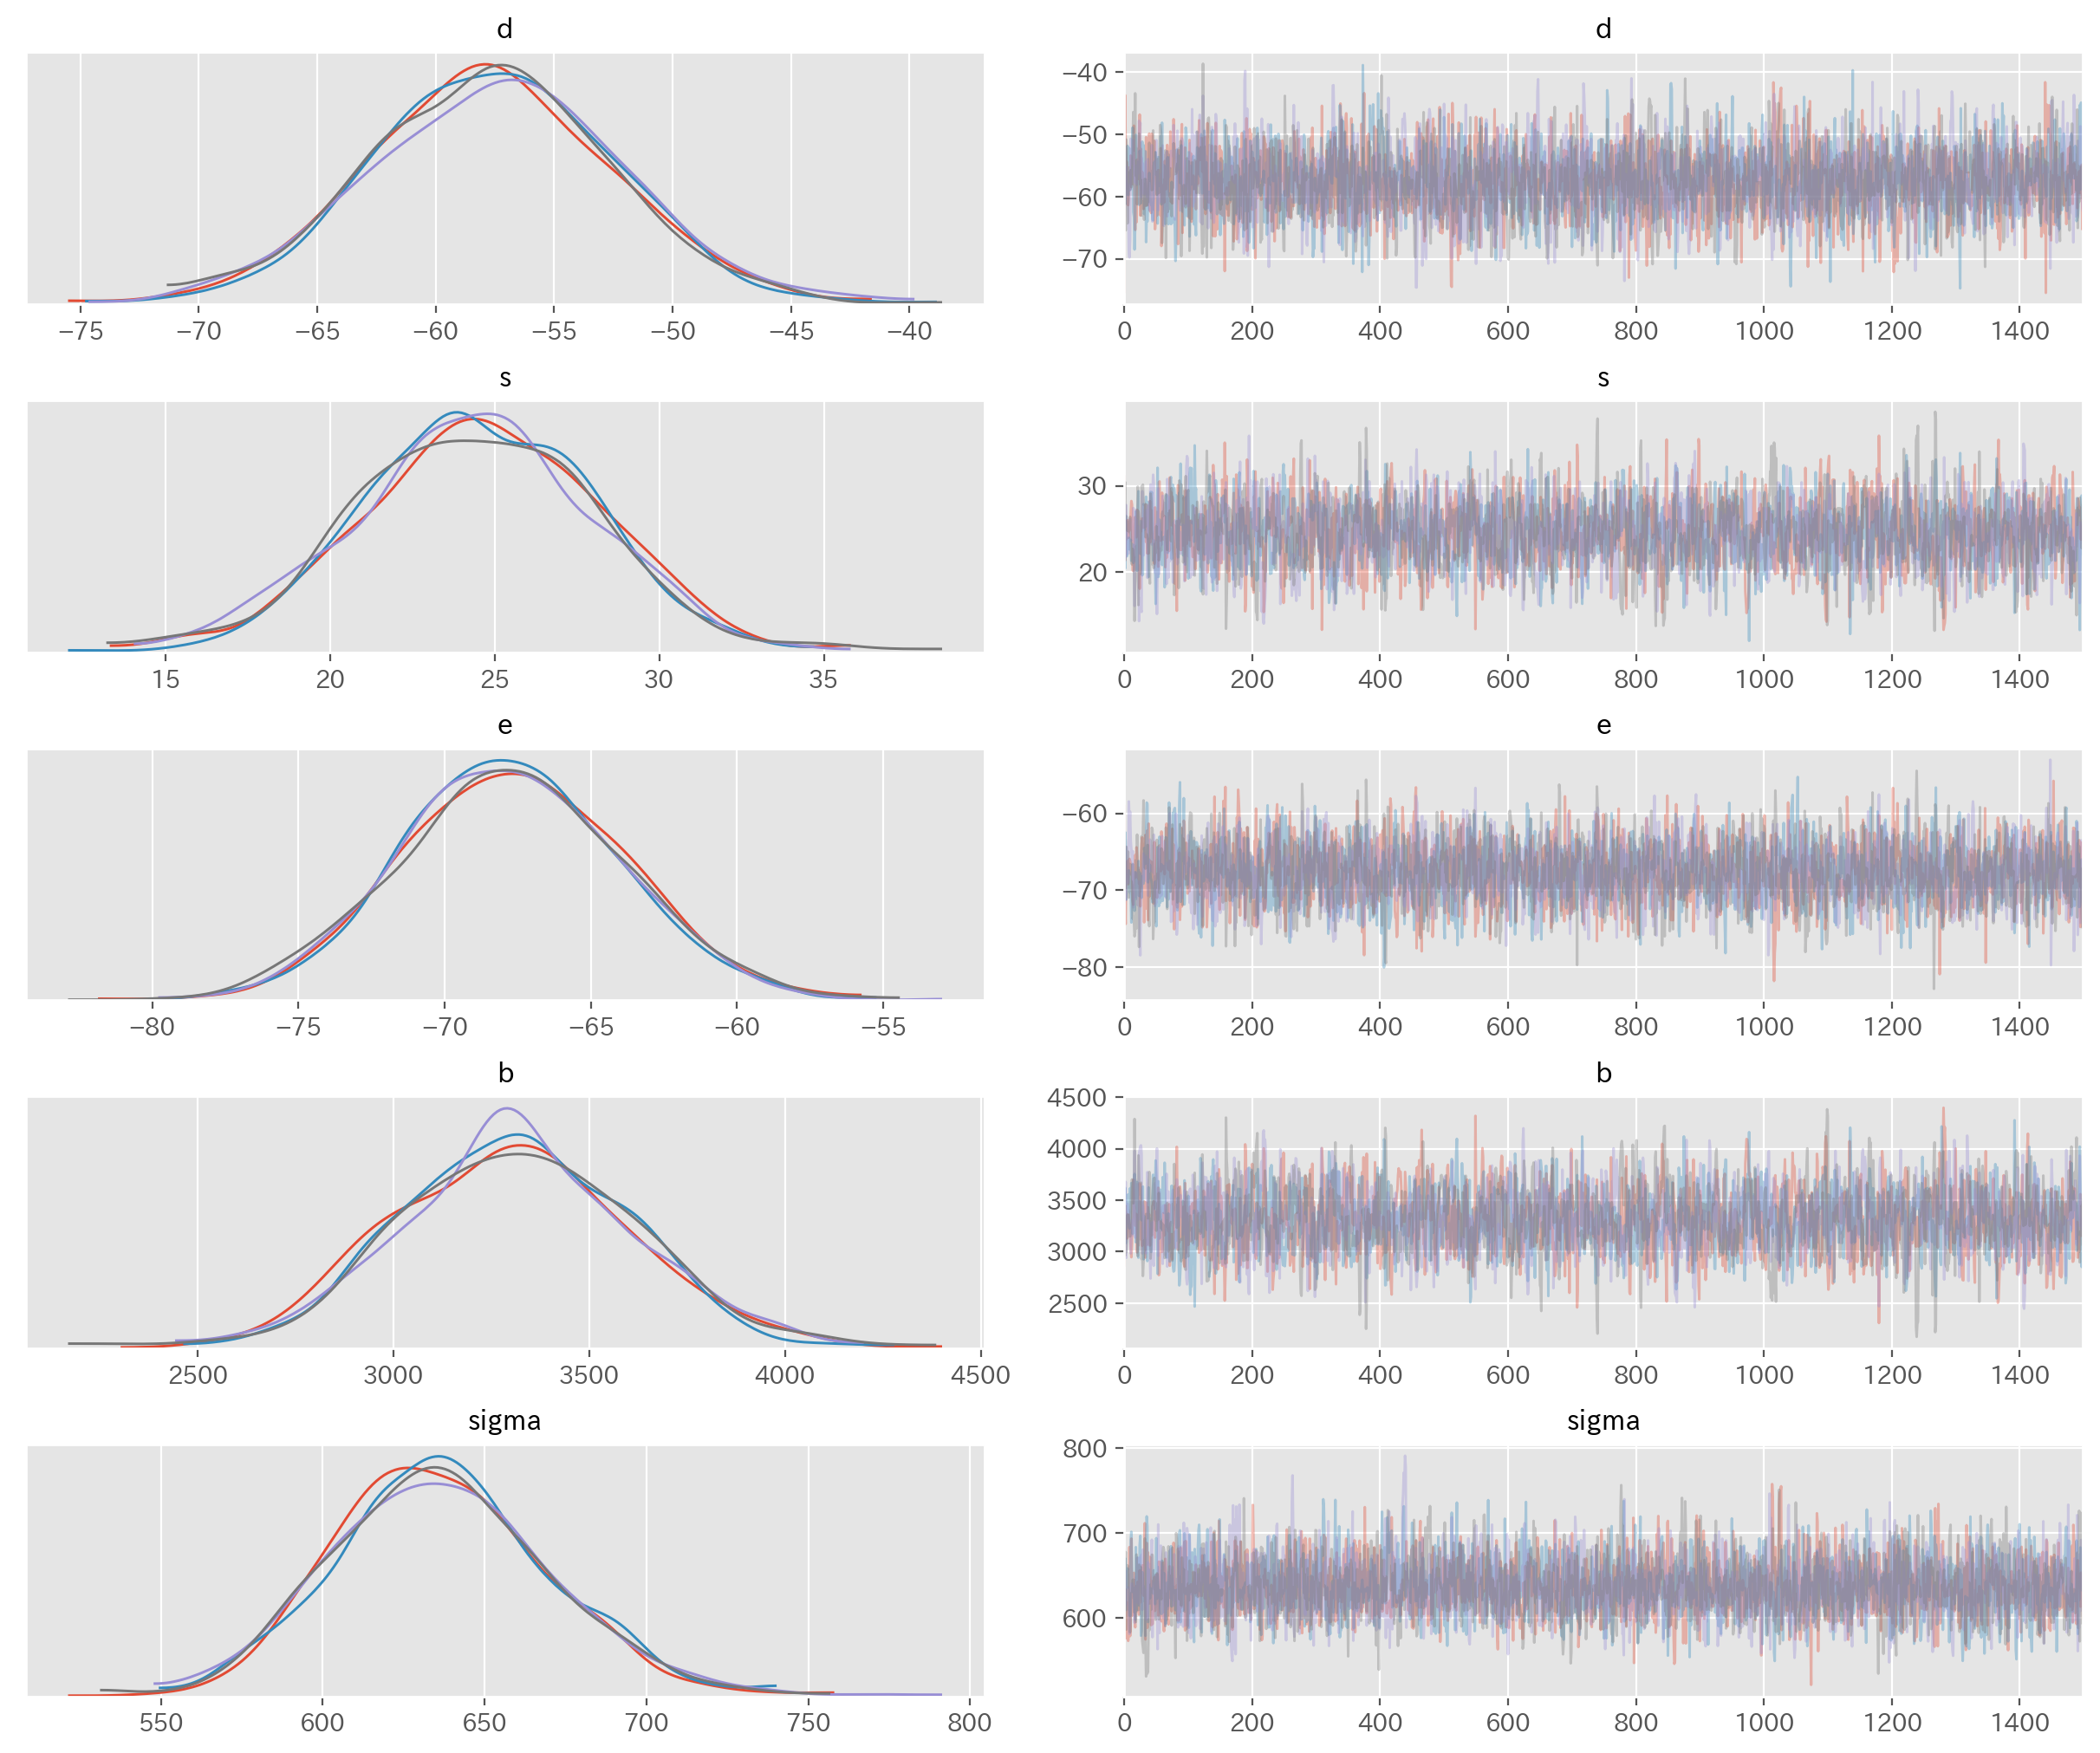

In [26]:
import arviz
arviz.plot_trace(fit);